In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [2]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 30

In [3]:
y1_step = .02
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [4]:
def solve_prep(y1_mat, y2_mat, γ3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol and episode  < max_iter:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-10] = 1e-10
        ems = ems_new*fraction + ems_old*(1 - fraction)
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [6]:
def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_prep, args_list)
    return res_list        

def postjump_list(args_list):
    res_list = ode_y_parallel(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    ems_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j] = res_list[j]['v0']
        ems_list[j] = res_list[j]['ems']
        
    return ϕ_list, ems_list

args_list_test  = []
for γ3_i in γ3_list:
    args_iter = (y1_mat, y2_mat, γ3_i, 1e-6, 0.001, 2000, 0.05)
    args_list_test.append(args_iter)
ϕ_list, ems_list = postjump_list(args_list_test)

Episode 2000: PDE Error: 0.106152514573; False Transient Error: 0.106144431845; Iterations: 228; CG Error: 0.000000000081
Episode 2000: PDE Error: 0.106152834637; False Transient Error: 0.106144772081; Iterations: 227; CG Error: 0.000000000088
Episode 2000: PDE Error: 0.106152544516; False Transient Error: 0.106144480394; Iterations: 229; CG Error: 0.000000000084
Episode 2000: PDE Error: 0.106152687611; False Transient Error: 0.106144621891; Iterations: 227; CG Error: 0.000000000093
Episode 2000: PDE Error: 0.106152556087; False Transient Error: 0.106144469425; Iterations: 228; CG Error: 0.000000000096
Episode 2000: PDE Error: 0.106152442993; False Transient Error: 0.106144373900; Iterations: 227; CG Error: 0.000000000099
Episode 2000: PDE Error: 0.106152668412; False Transient Error: 0.106144579153; Iterations: 228; CG Error: 0.000000000089
Episode 2000: PDE Error: 0.106152750855; False Transient Error: 0.106144684879; Iterations: 227; CG Error: 0.000000000092
Episode 2000: PDE Error:

In [7]:
np.save(f"v_list_{λ}", ϕ_list)
np.save(f"e_list_{λ}", ems_list)

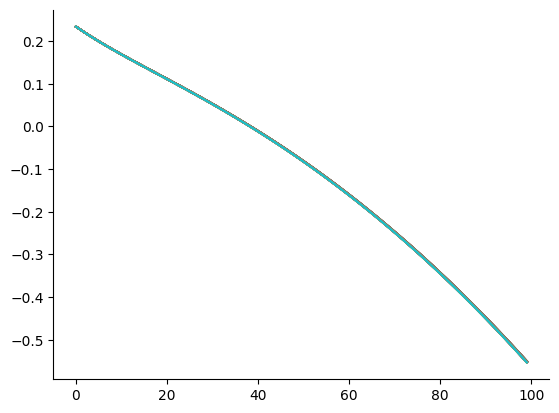

In [9]:
plt.plot(ϕ_list[0])
plt.show()

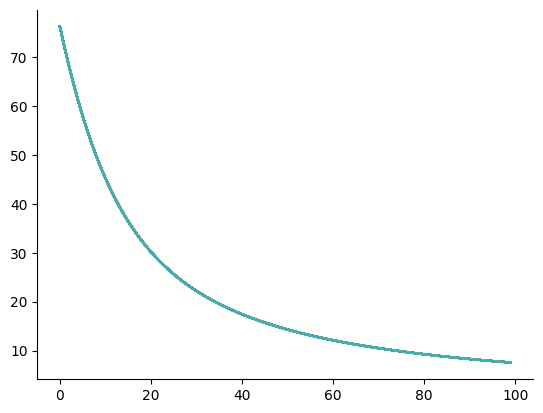

In [10]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [11]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1.
ϵ = 0.001
max_iter = 5000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)

# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][loc_2]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 0.02 + ems_old * 0.98
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.088604570035	 rhs error: 0.094478278525
Episode: 2	 lhs error: 0.103261912618	 rhs error: 0.109059432051
Episode: 3	 lhs error: 0.111382520493	 rhs error: 0.117111777704
Episode: 4	 lhs error: 0.116563787409	 rhs error: 0.122203331430
Episode: 5	 lhs error: 0.120005603859	 rhs error: 0.125621642081
Episode: 6	 lhs error: 0.122545545278	 rhs error: 0.127979651609
Episode: 7	 lhs error: 0.124044298995	 rhs error: 0.129613895005
Episode: 8	 lhs error: 0.125271855541	 rhs error: 0.130735555765
Episode: 9	 lhs error: 0.126186789721	 rhs error: 0.131475698478
Episode: 10	 lhs error: 0.126846188295	 rhs error: 0.131926581840
Episode: 11	 lhs error: 0.126988304605	 rhs error: 0.132153583324
Episode: 12	 lhs error: 0.126923706875	 rhs error: 0.132210610841
Episode: 13	 lhs error: 0.127044894762	 rhs error: 0.132133413191
Episode: 14	 lhs error: 0.127068928994	 rhs error: 0.131947322407
Episode: 15	 lhs error: 0.126664692345	 rhs error: 0.131672036024
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.111314035980	 rhs error: 0.117769953198
Episode: 126	 lhs error: 0.108504265421	 rhs error: 0.116691356297
Episode: 127	 lhs error: 0.108065432466	 rhs error: 0.107524296503
Episode: 128	 lhs error: 0.110317744436	 rhs error: 0.119835284498
Episode: 129	 lhs error: 0.107726700507	 rhs error: 0.112898594399
Episode: 130	 lhs error: 0.106644103596	 rhs error: 0.109838662384
Episode: 131	 lhs error: 0.106559778952	 rhs error: 0.108419596651
Episode: 132	 lhs error: 0.107466578364	 rhs error: 0.109673367577
Episode: 133	 lhs error: 0.107360338751	 rhs error: 0.109949908896
Episode: 134	 lhs error: 0.107124345761	 rhs error: 0.113464974279
Episode: 135	 lhs error: 0.105983905648	 rhs error: 0.109329651683
Episode: 136	 lhs error: 0.109830261264	 rhs error: 0.107598447643
Episode: 137	 lhs error: 0.109086137027	 rhs error: 0.128677378761
Episode: 138	 lhs error: 0.107113124096	 rhs error: 0.107526287554
Episode: 139	 lhs error: 0.107514937179	 rhs error: 0.11207148

Episode: 249	 lhs error: 0.104345653935	 rhs error: 0.115630561993
Episode: 250	 lhs error: 0.104338747194	 rhs error: 0.115584085294
Episode: 251	 lhs error: 0.104331395785	 rhs error: 0.115533652673
Episode: 252	 lhs error: 0.104323581929	 rhs error: 0.115478957927
Episode: 253	 lhs error: 0.104315291921	 rhs error: 0.115419652314
Episode: 254	 lhs error: 0.104306517390	 rhs error: 0.115355344586
Episode: 255	 lhs error: 0.104297256696	 rhs error: 0.115285604803
Episode: 256	 lhs error: 0.104287516438	 rhs error: 0.115209973192
Episode: 257	 lhs error: 0.104277313115	 rhs error: 0.115127975660
Episode: 258	 lhs error: 0.104266674891	 rhs error: 0.115039147811
Episode: 259	 lhs error: 0.104255643441	 rhs error: 0.114943069321
Episode: 260	 lhs error: 0.104244275702	 rhs error: 0.114839410039
Episode: 261	 lhs error: 0.104232645257	 rhs error: 0.114727988098
Episode: 262	 lhs error: 0.104220842871	 rhs error: 0.114608838050
Episode: 263	 lhs error: 0.104208975545	 rhs error: 0.11448228

Episode: 373	 lhs error: 0.108473893290	 rhs error: 0.129274625584
Episode: 374	 lhs error: 0.107919670277	 rhs error: 0.119039479921
Episode: 375	 lhs error: 0.105379712764	 rhs error: 0.119850061815
Episode: 376	 lhs error: 0.108156517662	 rhs error: 0.111732503136
Episode: 377	 lhs error: 0.111729815171	 rhs error: 0.130843534108
Episode: 378	 lhs error: 0.111163295417	 rhs error: 0.136146237855
Episode: 379	 lhs error: 0.107925685429	 rhs error: 0.126646287678
Episode: 380	 lhs error: 0.108663325769	 rhs error: 0.116709348959
Episode: 381	 lhs error: 0.107324173610	 rhs error: 0.126646678828
Episode: 382	 lhs error: 0.107342018793	 rhs error: 0.124174005488
Episode: 383	 lhs error: 0.107050262143	 rhs error: 0.112970916939
Episode: 384	 lhs error: 0.110093911513	 rhs error: 0.120303020143
Episode: 385	 lhs error: 0.108580396241	 rhs error: 0.137555273763
Episode: 386	 lhs error: 0.106534926281	 rhs error: 0.110626339618
Episode: 387	 lhs error: 0.109324241768	 rhs error: 0.12864797

Episode: 497	 lhs error: 0.104761207816	 rhs error: 0.147995306072
Episode: 498	 lhs error: 0.105748959789	 rhs error: 0.139481375357
Episode: 499	 lhs error: 0.106357732480	 rhs error: 0.155543517294
Episode: 500	 lhs error: 0.104648380826	 rhs error: 0.124437412426
Episode: 501	 lhs error: 0.106135077009	 rhs error: 0.145653992403
Episode: 502	 lhs error: 0.102878747619	 rhs error: 0.108344703449
Episode: 503	 lhs error: 0.106202617946	 rhs error: 0.108391925065
Episode: 504	 lhs error: 0.103305663202	 rhs error: 0.106997109135
Episode: 505	 lhs error: 0.103088140950	 rhs error: 0.106455007613
Episode: 506	 lhs error: 0.103027120838	 rhs error: 0.106222687632
Episode: 507	 lhs error: 0.103009985053	 rhs error: 0.106099328998
Episode: 508	 lhs error: 0.102978100686	 rhs error: 0.106006538841
Episode: 509	 lhs error: 0.102942827167	 rhs error: 0.105919080486
Episode: 510	 lhs error: 0.102908596224	 rhs error: 0.105830465489
Episode: 511	 lhs error: 0.102875902076	 rhs error: 0.10574046

Episode: 621	 lhs error: 0.106482250735	 rhs error: 0.106640228544
Episode: 622	 lhs error: 0.102349512964	 rhs error: 0.114050105519
Episode: 623	 lhs error: 0.103133725010	 rhs error: 0.117122373767
Episode: 624	 lhs error: 0.102595020553	 rhs error: 0.111668971563
Episode: 625	 lhs error: 0.102306492913	 rhs error: 0.112308597946
Episode: 626	 lhs error: 0.102288495884	 rhs error: 0.113001546090
Episode: 627	 lhs error: 0.102303329726	 rhs error: 0.112479258085
Episode: 628	 lhs error: 0.102283034286	 rhs error: 0.112182775855
Episode: 629	 lhs error: 0.102250388022	 rhs error: 0.111866968488
Episode: 630	 lhs error: 0.102229422265	 rhs error: 0.111546011841
Episode: 631	 lhs error: 0.102213294095	 rhs error: 0.111178516897
Episode: 632	 lhs error: 0.102198014145	 rhs error: 0.110808464255
Episode: 633	 lhs error: 0.102183739005	 rhs error: 0.110434382335
Episode: 634	 lhs error: 0.102170083342	 rhs error: 0.110054472029
Episode: 635	 lhs error: 0.102156481775	 rhs error: 0.10967260

Episode: 745	 lhs error: 0.107114225503	 rhs error: 0.154419952774
Episode: 746	 lhs error: 0.105723292804	 rhs error: 0.177834186655
Episode: 747	 lhs error: 0.106421875075	 rhs error: 0.126632978487
Episode: 748	 lhs error: 0.105416818080	 rhs error: 0.159412906784
Episode: 749	 lhs error: 0.103368489921	 rhs error: 0.158665744065
Episode: 750	 lhs error: 0.102636492878	 rhs error: 0.159521709920
Episode: 751	 lhs error: 0.103453728782	 rhs error: 0.151434150952
Episode: 752	 lhs error: 0.102986828198	 rhs error: 0.163689910057
Episode: 753	 lhs error: 0.103290099467	 rhs error: 0.145898042621
Episode: 754	 lhs error: 0.103293344232	 rhs error: 0.162564130152
Episode: 755	 lhs error: 0.102918470491	 rhs error: 0.144439393365
Episode: 756	 lhs error: 0.102832781790	 rhs error: 0.158594203020
Episode: 757	 lhs error: 0.102451355009	 rhs error: 0.144342442915
Episode: 758	 lhs error: 0.102302273671	 rhs error: 0.153889700173
Episode: 759	 lhs error: 0.101947426018	 rhs error: 0.14441625

Episode: 869	 lhs error: 0.099764151112	 rhs error: 0.103059361727
Episode: 870	 lhs error: 0.099774698564	 rhs error: 0.102880581445
Episode: 871	 lhs error: 0.099773100963	 rhs error: 0.102822651002
Episode: 872	 lhs error: 0.099765180571	 rhs error: 0.102797864489
Episode: 873	 lhs error: 0.099765670078	 rhs error: 0.102765143978
Episode: 874	 lhs error: 0.099767542038	 rhs error: 0.102722566626
Episode: 875	 lhs error: 0.099768556622	 rhs error: 0.102676124537
Episode: 876	 lhs error: 0.099769130439	 rhs error: 0.102629027647
Episode: 877	 lhs error: 0.099769079100	 rhs error: 0.102582141828
Episode: 878	 lhs error: 0.099768496034	 rhs error: 0.102535755222
Episode: 879	 lhs error: 0.099767693402	 rhs error: 0.102490105263
Episode: 880	 lhs error: 0.099766824343	 rhs error: 0.102445315532
Episode: 881	 lhs error: 0.099765897376	 rhs error: 0.102401385706
Episode: 882	 lhs error: 0.099764897502	 rhs error: 0.102358264312
Episode: 883	 lhs error: 0.099763824694	 rhs error: 0.10231589

Episode: 993	 lhs error: 0.099603455836	 rhs error: 0.115324772545
Episode: 994	 lhs error: 0.099597180843	 rhs error: 0.116334718336
Episode: 995	 lhs error: 0.099591602497	 rhs error: 0.117432972895
Episode: 996	 lhs error: 0.099586949058	 rhs error: 0.118637181889
Episode: 997	 lhs error: 0.099583546067	 rhs error: 0.119971949239
Episode: 998	 lhs error: 0.099581885567	 rhs error: 0.121471862204
Episode: 999	 lhs error: 0.099582777240	 rhs error: 0.123186769976
Episode: 1000	 lhs error: 0.099587704330	 rhs error: 0.125192004750
Episode: 1001	 lhs error: 0.099599781944	 rhs error: 0.127610649048
Episode: 1002	 lhs error: 0.099626950500	 rhs error: 0.130670691960
Episode: 1003	 lhs error: 0.099697190052	 rhs error: 0.134898317275
Episode: 1004	 lhs error: 0.100115000893	 rhs error: 0.142361332633
Episode: 1005	 lhs error: 0.100646969387	 rhs error: 0.152677222583
Episode: 1006	 lhs error: 0.102886311811	 rhs error: 0.152327989392
Episode: 1007	 lhs error: 0.104653680992	 rhs error: 0.

Episode: 1117	 lhs error: 0.101380042550	 rhs error: 0.107210101569
Episode: 1118	 lhs error: 0.100489590453	 rhs error: 0.112282059509
Episode: 1119	 lhs error: 0.102581853171	 rhs error: 0.114839610478
Episode: 1120	 lhs error: 0.101494735183	 rhs error: 0.109293653132
Episode: 1121	 lhs error: 0.104339287813	 rhs error: 0.104957639192
Episode: 1122	 lhs error: 0.104652200104	 rhs error: 0.113934800378
Episode: 1123	 lhs error: 0.105246546265	 rhs error: 0.108888252382
Episode: 1124	 lhs error: 0.105887063856	 rhs error: 0.115527737576
Episode: 1125	 lhs error: 0.105791670805	 rhs error: 0.128047538633
Episode: 1126	 lhs error: 0.104578343041	 rhs error: 0.110851161928
Episode: 1127	 lhs error: 0.104797832382	 rhs error: 0.131007682249
Episode: 1128	 lhs error: 0.104290565756	 rhs error: 0.123234411055
Episode: 1129	 lhs error: 0.103199376005	 rhs error: 0.115335869878
Episode: 1130	 lhs error: 0.103602755342	 rhs error: 0.117320049989
Episode: 1131	 lhs error: 0.102680042206	 rhs er

Episode: 1241	 lhs error: 0.103790124447	 rhs error: 0.115244371173
Episode: 1242	 lhs error: 0.102844102542	 rhs error: 0.106327055540
Episode: 1243	 lhs error: 0.107512984413	 rhs error: 0.113179825666
Episode: 1244	 lhs error: 0.104723561460	 rhs error: 0.133836960257
Episode: 1245	 lhs error: 0.101263125191	 rhs error: 0.140822364674
Episode: 1246	 lhs error: 0.106829191073	 rhs error: 0.140008457620
Episode: 1247	 lhs error: 0.108612941436	 rhs error: 0.124247759564
Episode: 1248	 lhs error: 0.102866450294	 rhs error: 0.114326665231
Episode: 1249	 lhs error: 0.107570242554	 rhs error: 0.108210829085
Episode: 1250	 lhs error: 0.118228533557	 rhs error: 0.141607668483
Episode: 1251	 lhs error: 0.108268176930	 rhs error: 0.133230271599
Episode: 1252	 lhs error: 0.104488543176	 rhs error: 0.127665910195
Episode: 1253	 lhs error: 0.101961199547	 rhs error: 0.114884070304
Episode: 1254	 lhs error: 0.107232076956	 rhs error: 0.107271228406
Episode: 1255	 lhs error: 0.102679089008	 rhs er

Episode: 1365	 lhs error: 0.098038529691	 rhs error: 0.127131640538
Episode: 1366	 lhs error: 0.100912618244	 rhs error: 0.122783193406
Episode: 1367	 lhs error: 0.099132592240	 rhs error: 0.111625201388
Episode: 1368	 lhs error: 0.097892856235	 rhs error: 0.113065760901
Episode: 1369	 lhs error: 0.097674591534	 rhs error: 0.113221852387
Episode: 1370	 lhs error: 0.097678259411	 rhs error: 0.113216561356
Episode: 1371	 lhs error: 0.097684513014	 rhs error: 0.113156405871
Episode: 1372	 lhs error: 0.097688847016	 rhs error: 0.113006633782
Episode: 1373	 lhs error: 0.097691528664	 rhs error: 0.112901646908
Episode: 1374	 lhs error: 0.097696431572	 rhs error: 0.112789793271
Episode: 1375	 lhs error: 0.097699001063	 rhs error: 0.112673908516
Episode: 1376	 lhs error: 0.097706699810	 rhs error: 0.112554529453
Episode: 1377	 lhs error: 0.097712878641	 rhs error: 0.112428265342
Episode: 1378	 lhs error: 0.097717891008	 rhs error: 0.112296406968
Episode: 1379	 lhs error: 0.097722605748	 rhs er

Episode: 1489	 lhs error: 0.097229002127	 rhs error: 0.104300903327
Episode: 1490	 lhs error: 0.097202801611	 rhs error: 0.103999184350
Episode: 1491	 lhs error: 0.104103442230	 rhs error: 0.103759629351
Episode: 1492	 lhs error: 0.101239669387	 rhs error: 0.112689699113
Episode: 1493	 lhs error: 0.098123704417	 rhs error: 0.101698532665
Episode: 1494	 lhs error: 0.103167969169	 rhs error: 0.103227532855
Episode: 1495	 lhs error: 0.099404863281	 rhs error: 0.110183336007
Episode: 1496	 lhs error: 0.101362657689	 rhs error: 0.115141324556
Episode: 1497	 lhs error: 0.102038089965	 rhs error: 0.100880445095
Episode: 1498	 lhs error: 0.098097154027	 rhs error: 0.109829762920
Episode: 1499	 lhs error: 0.097901453146	 rhs error: 0.110835117271
Episode: 1500	 lhs error: 0.098093572400	 rhs error: 0.109442823255
Episode: 1501	 lhs error: 0.098138880871	 rhs error: 0.106660372492
Episode: 1502	 lhs error: 0.098024941560	 rhs error: 0.102539606416
Episode: 1503	 lhs error: 0.102295079022	 rhs er

Episode: 1613	 lhs error: 0.095965976355	 rhs error: 0.134213748935
Episode: 1614	 lhs error: 0.095950545385	 rhs error: 0.127122956429
Episode: 1615	 lhs error: 0.095936921646	 rhs error: 0.127191970666
Episode: 1616	 lhs error: 0.097348726687	 rhs error: 0.127226275838
Episode: 1617	 lhs error: 0.096698674876	 rhs error: 0.138392610537
Episode: 1618	 lhs error: 0.096712714358	 rhs error: 0.157754719369
Episode: 1619	 lhs error: 0.096912682985	 rhs error: 0.133017255804
Episode: 1620	 lhs error: 0.096829043423	 rhs error: 0.127370818203
Episode: 1621	 lhs error: 0.095787586943	 rhs error: 0.126943321505
Episode: 1622	 lhs error: 0.095771380180	 rhs error: 0.126850046363
Episode: 1623	 lhs error: 0.095789485012	 rhs error: 0.126699048412
Episode: 1624	 lhs error: 0.095823921614	 rhs error: 0.126459975028
Episode: 1625	 lhs error: 0.095900422517	 rhs error: 0.126113999711
Episode: 1626	 lhs error: 0.096096581477	 rhs error: 0.125574866478
Episode: 1627	 lhs error: 0.096490441817	 rhs er

Episode: 1737	 lhs error: 0.096883288112	 rhs error: 0.136057595610
Episode: 1738	 lhs error: 0.097148334384	 rhs error: 0.134121504766
Episode: 1739	 lhs error: 0.096927055885	 rhs error: 0.131547770421
Episode: 1740	 lhs error: 0.096965133585	 rhs error: 0.127808460342
Episode: 1741	 lhs error: 0.096679803440	 rhs error: 0.123834802579
Episode: 1742	 lhs error: 0.097958109688	 rhs error: 0.122104602965
Episode: 1743	 lhs error: 0.097305678522	 rhs error: 0.114660634951
Episode: 1744	 lhs error: 0.103044175782	 rhs error: 0.137579292386
Episode: 1745	 lhs error: 0.106119889800	 rhs error: 0.128641730649
Episode: 1746	 lhs error: 0.098647424232	 rhs error: 0.132396123148
Episode: 1747	 lhs error: 0.099010994473	 rhs error: 0.107629969836
Episode: 1748	 lhs error: 0.096450734938	 rhs error: 0.124954091839
Episode: 1749	 lhs error: 0.097192779031	 rhs error: 0.129459389191
Episode: 1750	 lhs error: 0.097197527273	 rhs error: 0.113511722555
Episode: 1751	 lhs error: 0.099992095874	 rhs er

Episode: 1861	 lhs error: 0.098599152976	 rhs error: 0.130441335561
Episode: 1862	 lhs error: 0.101777810852	 rhs error: 0.144105842525
Episode: 1863	 lhs error: 0.100830404516	 rhs error: 0.132968854512
Episode: 1864	 lhs error: 0.103247375806	 rhs error: 0.163751634275
Episode: 1865	 lhs error: 0.103047465363	 rhs error: 0.142863464988
Episode: 1866	 lhs error: 0.103462785427	 rhs error: 0.103695447224
Episode: 1867	 lhs error: 0.104589028418	 rhs error: 0.146393476757
Episode: 1868	 lhs error: 0.096753196716	 rhs error: 0.110295166864
Episode: 1869	 lhs error: 0.098118538384	 rhs error: 0.125422551995
Episode: 1870	 lhs error: 0.098159052164	 rhs error: 0.104154988917
Episode: 1871	 lhs error: 0.097352902169	 rhs error: 0.117838047018
Episode: 1872	 lhs error: 0.100425522335	 rhs error: 0.132026660002
Episode: 1873	 lhs error: 0.095742382065	 rhs error: 0.110160638052
Episode: 1874	 lhs error: 0.100225270664	 rhs error: 0.103237744350
Episode: 1875	 lhs error: 0.099955180108	 rhs er

Episode: 1985	 lhs error: 0.096397328975	 rhs error: 0.113512758545
Episode: 1986	 lhs error: 0.096007447107	 rhs error: 0.104678638462
Episode: 1987	 lhs error: 0.094790961608	 rhs error: 0.100729022376
Episode: 1988	 lhs error: 0.094541814076	 rhs error: 0.100961639284
Episode: 1989	 lhs error: 0.094386708102	 rhs error: 0.100880278538
Episode: 1990	 lhs error: 0.094441434162	 rhs error: 0.100646288580
Episode: 1991	 lhs error: 0.097979656779	 rhs error: 0.100474793422
Episode: 1992	 lhs error: 0.096784001725	 rhs error: 0.112717178258
Episode: 1993	 lhs error: 0.095651684806	 rhs error: 0.101800197456
Episode: 1994	 lhs error: 0.094651155089	 rhs error: 0.100231663353
Episode: 1995	 lhs error: 0.098112609085	 rhs error: 0.100008529178
Episode: 1996	 lhs error: 0.097323734508	 rhs error: 0.113355288342
Episode: 1997	 lhs error: 0.095274163570	 rhs error: 0.103548335188
Episode: 1998	 lhs error: 0.094595288436	 rhs error: 0.099996850277
Episode: 1999	 lhs error: 0.097238233568	 rhs er

Episode: 2109	 lhs error: 0.106070692670	 rhs error: 0.145865726285
Episode: 2110	 lhs error: 0.095510641797	 rhs error: 0.107926749216
Episode: 2111	 lhs error: 0.102152984565	 rhs error: 0.102102738981
Episode: 2112	 lhs error: 0.097535761352	 rhs error: 0.131218380745
Episode: 2113	 lhs error: 0.094861187875	 rhs error: 0.120245229890
Episode: 2114	 lhs error: 0.096505319379	 rhs error: 0.172511014936
Episode: 2115	 lhs error: 0.096303275102	 rhs error: 0.123106921873
Episode: 2116	 lhs error: 0.103108435048	 rhs error: 0.140560113225
Episode: 2117	 lhs error: 0.096496288995	 rhs error: 0.111422694579
Episode: 2118	 lhs error: 0.095587691259	 rhs error: 0.112467455932
Episode: 2119	 lhs error: 0.094706687143	 rhs error: 0.112908986327
Episode: 2120	 lhs error: 0.094361907467	 rhs error: 0.112532325534
Episode: 2121	 lhs error: 0.095009923624	 rhs error: 0.111806477546
Episode: 2122	 lhs error: 0.094603145209	 rhs error: 0.112988675716
Episode: 2123	 lhs error: 0.093959568373	 rhs er

Episode: 2233	 lhs error: 0.092960020904	 rhs error: 0.100771651688
Episode: 2234	 lhs error: 0.092962141116	 rhs error: 0.100631712536
Episode: 2235	 lhs error: 0.092963670037	 rhs error: 0.100499831908
Episode: 2236	 lhs error: 0.092964826845	 rhs error: 0.100377779241
Episode: 2237	 lhs error: 0.092965868226	 rhs error: 0.100265806028
Episode: 2238	 lhs error: 0.092967034767	 rhs error: 0.100162764450
Episode: 2239	 lhs error: 0.092968516584	 rhs error: 0.100066451098
Episode: 2240	 lhs error: 0.092970431464	 rhs error: 0.099974064888
Episode: 2241	 lhs error: 0.092972809304	 rhs error: 0.099882700172
Episode: 2242	 lhs error: 0.092975583953	 rhs error: 0.099789819656
Episode: 2243	 lhs error: 0.092978599163	 rhs error: 0.099693653751
Episode: 2244	 lhs error: 0.092981634078	 rhs error: 0.099593466595
Episode: 2245	 lhs error: 0.092984446988	 rhs error: 0.099489635015
Episode: 2246	 lhs error: 0.092986827829	 rhs error: 0.099383514913
Episode: 2247	 lhs error: 0.092988644740	 rhs er

Episode: 2357	 lhs error: 0.095032585919	 rhs error: 0.125759981298
Episode: 2358	 lhs error: 0.094678584190	 rhs error: 0.116890206833
Episode: 2359	 lhs error: 0.095767707654	 rhs error: 0.121733385159
Episode: 2360	 lhs error: 0.094171187065	 rhs error: 0.119624371764
Episode: 2361	 lhs error: 0.096361016297	 rhs error: 0.122129400207
Episode: 2362	 lhs error: 0.094243503002	 rhs error: 0.121705515873
Episode: 2363	 lhs error: 0.097107549920	 rhs error: 0.122175582738
Episode: 2364	 lhs error: 0.095632121021	 rhs error: 0.123640898811
Episode: 2365	 lhs error: 0.099610158148	 rhs error: 0.126099988117
Episode: 2366	 lhs error: 0.099263396815	 rhs error: 0.128309224625
Episode: 2367	 lhs error: 0.099422233793	 rhs error: 0.170663183998
Episode: 2368	 lhs error: 0.102543895907	 rhs error: 0.223648636186
Episode: 2369	 lhs error: 0.096444538137	 rhs error: 0.130903269761
Episode: 2370	 lhs error: 0.093413040256	 rhs error: 0.137407752287
Episode: 2371	 lhs error: 0.094711288159	 rhs er

Episode: 2481	 lhs error: 0.094047587287	 rhs error: 0.101119666306
Episode: 2482	 lhs error: 0.097143616024	 rhs error: 0.100405554296
Episode: 2483	 lhs error: 0.093908472296	 rhs error: 0.108959062845
Episode: 2484	 lhs error: 0.096123478436	 rhs error: 0.104694338706
Episode: 2485	 lhs error: 0.093329932702	 rhs error: 0.099873059762
Episode: 2486	 lhs error: 0.094076089500	 rhs error: 0.102425507759
Episode: 2487	 lhs error: 0.093527240602	 rhs error: 0.098516133001
Episode: 2488	 lhs error: 0.100156664760	 rhs error: 0.100850613983
Episode: 2489	 lhs error: 0.097407235716	 rhs error: 0.115000479598
Episode: 2490	 lhs error: 0.097457788214	 rhs error: 0.098845877158
Episode: 2491	 lhs error: 0.093850460880	 rhs error: 0.101220823828
Episode: 2492	 lhs error: 0.097966138924	 rhs error: 0.105800392494
Episode: 2493	 lhs error: 0.099911169718	 rhs error: 0.120124559785
Episode: 2494	 lhs error: 0.099638932258	 rhs error: 0.118529900940
Episode: 2495	 lhs error: 0.097318428941	 rhs er

Episode: 2605	 lhs error: 0.092658651456	 rhs error: 0.318834036937
Episode: 2606	 lhs error: 0.092643909561	 rhs error: 0.313635233120
Episode: 2607	 lhs error: 0.092627183777	 rhs error: 0.308203506696
Episode: 2608	 lhs error: 0.092607857733	 rhs error: 0.302571408730
Episode: 2609	 lhs error: 0.092586362428	 rhs error: 0.296749886727
Episode: 2610	 lhs error: 0.092562670839	 rhs error: 0.290764919118
Episode: 2611	 lhs error: 0.092536981489	 rhs error: 0.284642598009
Episode: 2612	 lhs error: 0.092509398720	 rhs error: 0.278414925029
Episode: 2613	 lhs error: 0.092480080431	 rhs error: 0.272117410613
Episode: 2614	 lhs error: 0.092449166021	 rhs error: 0.265789665566
Episode: 2615	 lhs error: 0.092422943864	 rhs error: 0.259474781483
Episode: 2616	 lhs error: 0.092408753693	 rhs error: 0.253219047481
Episode: 2617	 lhs error: 0.092394895157	 rhs error: 0.247071438828
Episode: 2618	 lhs error: 0.092381539300	 rhs error: 0.241083041070
Episode: 2619	 lhs error: 0.092368842029	 rhs er

Episode: 2729	 lhs error: 0.090936898449	 rhs error: 0.105722454592
Episode: 2730	 lhs error: 0.090940462172	 rhs error: 0.105495900680
Episode: 2731	 lhs error: 0.090943852073	 rhs error: 0.105260446071
Episode: 2732	 lhs error: 0.090947074686	 rhs error: 0.105017433767
Episode: 2733	 lhs error: 0.090950134622	 rhs error: 0.104768266752
Episode: 2734	 lhs error: 0.090953707790	 rhs error: 0.104514413986
Episode: 2735	 lhs error: 0.090956998559	 rhs error: 0.104257415600
Episode: 2736	 lhs error: 0.090959910141	 rhs error: 0.103998891571
Episode: 2737	 lhs error: 0.090962440466	 rhs error: 0.103740556140
Episode: 2738	 lhs error: 0.090964583590	 rhs error: 0.103484237915
Episode: 2739	 lhs error: 0.090966328108	 rhs error: 0.103231910941
Episode: 2740	 lhs error: 0.090967654609	 rhs error: 0.102985740795
Episode: 2741	 lhs error: 0.090968842026	 rhs error: 0.102748154217
Episode: 2742	 lhs error: 0.090970372984	 rhs error: 0.102521945601
Episode: 2743	 lhs error: 0.090971667429	 rhs er

Episode: 2853	 lhs error: 0.096182111617	 rhs error: 0.118095717560
Episode: 2854	 lhs error: 0.092523301993	 rhs error: 0.100956345352
Episode: 2855	 lhs error: 0.096173504273	 rhs error: 0.117961215140
Episode: 2856	 lhs error: 0.092500123550	 rhs error: 0.100933460655
Episode: 2857	 lhs error: 0.096164271693	 rhs error: 0.117829291591
Episode: 2858	 lhs error: 0.092477495893	 rhs error: 0.100907470811
Episode: 2859	 lhs error: 0.096154431877	 rhs error: 0.117700053128
Episode: 2860	 lhs error: 0.092455391736	 rhs error: 0.100878619172
Episode: 2861	 lhs error: 0.096144002631	 rhs error: 0.117573589246
Episode: 2862	 lhs error: 0.092433786676	 rhs error: 0.100847145355
Episode: 2863	 lhs error: 0.096133002002	 rhs error: 0.117449973962
Episode: 2864	 lhs error: 0.092412659158	 rhs error: 0.100813285098
Episode: 2865	 lhs error: 0.096121448725	 rhs error: 0.117329267017
Episode: 2866	 lhs error: 0.092391990375	 rhs error: 0.100777270021
Episode: 2867	 lhs error: 0.096109362586	 rhs er

Episode: 2977	 lhs error: 0.094361178194	 rhs error: 0.098987037985
Episode: 2978	 lhs error: 0.095726260195	 rhs error: 0.120757274405
Episode: 2979	 lhs error: 0.094862815260	 rhs error: 0.100890593569
Episode: 2980	 lhs error: 0.099896428316	 rhs error: 0.113427404719
Episode: 2981	 lhs error: 0.094967399336	 rhs error: 0.128755316279
Episode: 2982	 lhs error: 0.090886138498	 rhs error: 0.101454614315
Episode: 2983	 lhs error: 0.090361756524	 rhs error: 0.100905242289
Episode: 2984	 lhs error: 0.090044917199	 rhs error: 0.101237399908
Episode: 2985	 lhs error: 0.089897256418	 rhs error: 0.101459733737
Episode: 2986	 lhs error: 0.089835762690	 rhs error: 0.101659770834
Episode: 2987	 lhs error: 0.089814036832	 rhs error: 0.101852212805
Episode: 2988	 lhs error: 0.089811253290	 rhs error: 0.102066736887
Episode: 2989	 lhs error: 0.089818553979	 rhs error: 0.102328581906
Episode: 2990	 lhs error: 0.089832377677	 rhs error: 0.102656293501
Episode: 2991	 lhs error: 0.089851044680	 rhs er

Episode: 3101	 lhs error: 0.102426653533	 rhs error: 0.182238441457
Episode: 3102	 lhs error: 0.103533259409	 rhs error: 0.171450044327
Episode: 3103	 lhs error: 0.097943990288	 rhs error: 0.282727294410
Episode: 3104	 lhs error: 0.094634527018	 rhs error: 0.283821407171
Episode: 3105	 lhs error: 0.096180641588	 rhs error: 0.136460751605
Episode: 3106	 lhs error: 0.090842232925	 rhs error: 0.120142652892
Episode: 3107	 lhs error: 0.089882197190	 rhs error: 0.114273397580
Episode: 3108	 lhs error: 0.089923636442	 rhs error: 0.112220491737
Episode: 3109	 lhs error: 0.090187476551	 rhs error: 0.110444342981
Episode: 3110	 lhs error: 0.090369551821	 rhs error: 0.109594159262
Episode: 3111	 lhs error: 0.096240680863	 rhs error: 0.129437289919
Episode: 3112	 lhs error: 0.098397846810	 rhs error: 0.113301970455
Episode: 3113	 lhs error: 0.098364695686	 rhs error: 0.158325980184
Episode: 3114	 lhs error: 0.092179029334	 rhs error: 0.105214517950
Episode: 3115	 lhs error: 0.101557456189	 rhs er

Episode: 3225	 lhs error: 0.101145712053	 rhs error: 0.129109060946
Episode: 3226	 lhs error: 0.095503664952	 rhs error: 0.160802401971
Episode: 3227	 lhs error: 0.094847550443	 rhs error: 0.125751504835
Episode: 3228	 lhs error: 0.101981144664	 rhs error: 0.121264010588
Episode: 3229	 lhs error: 0.099222673902	 rhs error: 0.119340893550
Episode: 3230	 lhs error: 0.105443877470	 rhs error: 0.167799390604
Episode: 3231	 lhs error: 0.103413739426	 rhs error: 0.114275042220
Episode: 3232	 lhs error: 0.104874185470	 rhs error: 0.156317881115
Episode: 3233	 lhs error: 0.096080847481	 rhs error: 0.134554007282
Episode: 3234	 lhs error: 0.096203219794	 rhs error: 0.114869146122
Episode: 3235	 lhs error: 0.107406116570	 rhs error: 0.160789018961
Episode: 3236	 lhs error: 0.099538765863	 rhs error: 0.129150964258
Episode: 3237	 lhs error: 0.097201933879	 rhs error: 0.144131386189
Episode: 3238	 lhs error: 0.100599170075	 rhs error: 0.148978322566
Episode: 3239	 lhs error: 0.099767330702	 rhs er

Episode: 3349	 lhs error: 0.091172407895	 rhs error: 0.141812330812
Episode: 3350	 lhs error: 0.107298075158	 rhs error: 0.169320212160
Episode: 3351	 lhs error: 0.113896889513	 rhs error: 0.185616178909
Episode: 3352	 lhs error: 0.099839296480	 rhs error: 0.144189563694
Episode: 3353	 lhs error: 0.094191154624	 rhs error: 0.165532714356
Episode: 3354	 lhs error: 0.099290049348	 rhs error: 0.170697910987
Episode: 3355	 lhs error: 0.100886661083	 rhs error: 0.194893570018
Episode: 3356	 lhs error: 0.092963708940	 rhs error: 0.115891002958
Episode: 3357	 lhs error: 0.105275328705	 rhs error: 0.204320652862
Episode: 3358	 lhs error: 0.112492000920	 rhs error: 0.206965610732
Episode: 3359	 lhs error: 0.092011615431	 rhs error: 0.140666644137
Episode: 3360	 lhs error: 0.103491027792	 rhs error: 0.110022431948
Episode: 3361	 lhs error: 0.111075910543	 rhs error: 0.198769444196
Episode: 3362	 lhs error: 0.107700964896	 rhs error: 0.111362895316
Episode: 3363	 lhs error: 0.104257694661	 rhs er

Episode: 3473	 lhs error: 0.087680519336	 rhs error: 0.109513691246
Episode: 3474	 lhs error: 0.087674152039	 rhs error: 0.109414599080
Episode: 3475	 lhs error: 0.087671767899	 rhs error: 0.109301225738
Episode: 3476	 lhs error: 0.087672161060	 rhs error: 0.109175800932
Episode: 3477	 lhs error: 0.087674525571	 rhs error: 0.109040010136
Episode: 3478	 lhs error: 0.087678329496	 rhs error: 0.108895189362
Episode: 3479	 lhs error: 0.087683212046	 rhs error: 0.108742426626
Episode: 3480	 lhs error: 0.095698026199	 rhs error: 0.108582735685
Episode: 3481	 lhs error: 0.120445669179	 rhs error: 0.149949495802
Episode: 3482	 lhs error: 0.103218923056	 rhs error: 0.387470601813
Episode: 3483	 lhs error: 0.093874639301	 rhs error: 0.105998090049
Episode: 3484	 lhs error: 0.098605005399	 rhs error: 0.115614874276
Episode: 3485	 lhs error: 0.093754738913	 rhs error: 0.106584904530
Episode: 3486	 lhs error: 0.090206483996	 rhs error: 0.119367927522
Episode: 3487	 lhs error: 0.094741363982	 rhs er

Episode: 3597	 lhs error: 0.090559977970	 rhs error: 0.104498951910
Episode: 3598	 lhs error: 0.089049352546	 rhs error: 0.099397821086
Episode: 3599	 lhs error: 0.088058753755	 rhs error: 0.102625171623
Episode: 3600	 lhs error: 0.087911334627	 rhs error: 0.101696223197
Episode: 3601	 lhs error: 0.087977938865	 rhs error: 0.101648727648
Episode: 3602	 lhs error: 0.095067588626	 rhs error: 0.101394923665
Episode: 3603	 lhs error: 0.093568142121	 rhs error: 0.167064027959
Episode: 3604	 lhs error: 0.100883844757	 rhs error: 0.141237627397
Episode: 3605	 lhs error: 0.094150928625	 rhs error: 0.118016421603
Episode: 3606	 lhs error: 0.091500028667	 rhs error: 0.117269996306
Episode: 3607	 lhs error: 0.093754482599	 rhs error: 0.107375684068
Episode: 3608	 lhs error: 0.094931348746	 rhs error: 0.115039649367
Episode: 3609	 lhs error: 0.092177317389	 rhs error: 0.108048967107
Episode: 3610	 lhs error: 0.090804259761	 rhs error: 0.096107888028
Episode: 3611	 lhs error: 0.093252671672	 rhs er

Episode: 3721	 lhs error: 0.099732108554	 rhs error: 0.154252296678
Episode: 3722	 lhs error: 0.093299086103	 rhs error: 0.135809642667
Episode: 3723	 lhs error: 0.089320166861	 rhs error: 0.125772112268
Episode: 3724	 lhs error: 0.088663697618	 rhs error: 0.153017977556
Episode: 3725	 lhs error: 0.091017952786	 rhs error: 0.150510767912
Episode: 3726	 lhs error: 0.095368846562	 rhs error: 0.121378153695
Episode: 3727	 lhs error: 0.093172852499	 rhs error: 0.145571738416
Episode: 3728	 lhs error: 0.091103365412	 rhs error: 0.204975549703
Episode: 3729	 lhs error: 0.090095761645	 rhs error: 0.235126379447
Episode: 3730	 lhs error: 0.088786849258	 rhs error: 0.220431927363
Episode: 3731	 lhs error: 0.087737556897	 rhs error: 0.185501311262
Episode: 3732	 lhs error: 0.087663069993	 rhs error: 0.160553753812
Episode: 3733	 lhs error: 0.087912348172	 rhs error: 0.150373852252
Episode: 3734	 lhs error: 0.088268730396	 rhs error: 0.149299343383
Episode: 3735	 lhs error: 0.088669461106	 rhs er

Episode: 3845	 lhs error: 0.094923220629	 rhs error: 0.107569394484
Episode: 3846	 lhs error: 0.096035350615	 rhs error: 0.102548904043
Episode: 3847	 lhs error: 0.092312661118	 rhs error: 0.107302637021
Episode: 3848	 lhs error: 0.095203473564	 rhs error: 0.101712270812
Episode: 3849	 lhs error: 0.092555366610	 rhs error: 0.108504320504
Episode: 3850	 lhs error: 0.095146179941	 rhs error: 0.101582927150
Episode: 3851	 lhs error: 0.091958962931	 rhs error: 0.109778024023
Episode: 3852	 lhs error: 0.095246075480	 rhs error: 0.103164413956
Episode: 3853	 lhs error: 0.091440006672	 rhs error: 0.111460520163
Episode: 3854	 lhs error: 0.095379692305	 rhs error: 0.106947566938
Episode: 3855	 lhs error: 0.092795826935	 rhs error: 0.114276165504
Episode: 3856	 lhs error: 0.091201601943	 rhs error: 0.139475090678
Episode: 3857	 lhs error: 0.097839991879	 rhs error: 0.104460338734
Episode: 3858	 lhs error: 0.097781838840	 rhs error: 0.113751247422
Episode: 3859	 lhs error: 0.096767721735	 rhs er

Episode: 3969	 lhs error: 0.088574051104	 rhs error: 0.098797781730
Episode: 3970	 lhs error: 0.092601401887	 rhs error: 0.110711829712
Episode: 3971	 lhs error: 0.092762686303	 rhs error: 0.128753562584
Episode: 3972	 lhs error: 0.087963241402	 rhs error: 0.110308728883
Episode: 3973	 lhs error: 0.097874979349	 rhs error: 0.101223700841
Episode: 3974	 lhs error: 0.097644046055	 rhs error: 0.116092150255
Episode: 3975	 lhs error: 0.095635454438	 rhs error: 0.102557356310
Episode: 3976	 lhs error: 0.094853919841	 rhs error: 0.108674841054
Episode: 3977	 lhs error: 0.097350440688	 rhs error: 0.103004383648
Episode: 3978	 lhs error: 0.093829482347	 rhs error: 0.104166673522
Episode: 3979	 lhs error: 0.098826529564	 rhs error: 0.103998007511
Episode: 3980	 lhs error: 0.091528138734	 rhs error: 0.102613363986
Episode: 3981	 lhs error: 0.095910782489	 rhs error: 0.135558530773
Episode: 3982	 lhs error: 0.088502891342	 rhs error: 0.103201419213
Episode: 3983	 lhs error: 0.087060339908	 rhs er

Episode: 4093	 lhs error: 0.086684313793	 rhs error: 0.162081412155
Episode: 4094	 lhs error: 0.086681520050	 rhs error: 0.153831620397
Episode: 4095	 lhs error: 0.086680997983	 rhs error: 0.145923010951
Episode: 4096	 lhs error: 0.086680660835	 rhs error: 0.138334816303
Episode: 4097	 lhs error: 0.086680107347	 rhs error: 0.131046905785
Episode: 4098	 lhs error: 0.086679365425	 rhs error: 0.124039830179
Episode: 4099	 lhs error: 0.086678459984	 rhs error: 0.123029874683
Episode: 4100	 lhs error: 0.086681576422	 rhs error: 0.122511391720
Episode: 4101	 lhs error: 0.086684931033	 rhs error: 0.121994453110
Episode: 4102	 lhs error: 0.086688137851	 rhs error: 0.121479206757
Episode: 4103	 lhs error: 0.086691216652	 rhs error: 0.120965790065
Episode: 4104	 lhs error: 0.086694189352	 rhs error: 0.120454329436
Episode: 4105	 lhs error: 0.086697080151	 rhs error: 0.119944939943
Episode: 4106	 lhs error: 0.086699915754	 rhs error: 0.119437724579
Episode: 4107	 lhs error: 0.086702725661	 rhs er

Episode: 4217	 lhs error: 0.086657970725	 rhs error: 0.371123827717
Episode: 4218	 lhs error: 0.086635257173	 rhs error: 0.371128365213
Episode: 4219	 lhs error: 0.086616077966	 rhs error: 0.369963234788
Episode: 4220	 lhs error: 0.086598586394	 rhs error: 0.367657143293
Episode: 4221	 lhs error: 0.086582040899	 rhs error: 0.364397457742
Episode: 4222	 lhs error: 0.086566162973	 rhs error: 0.360363863357
Episode: 4223	 lhs error: 0.086550825083	 rhs error: 0.355698135218
Episode: 4224	 lhs error: 0.086538695861	 rhs error: 0.350508379311
Episode: 4225	 lhs error: 0.086532043274	 rhs error: 0.344882774779
Episode: 4226	 lhs error: 0.086525596190	 rhs error: 0.338895009949
Episode: 4227	 lhs error: 0.086519507112	 rhs error: 0.332607597195
Episode: 4228	 lhs error: 0.086513893469	 rhs error: 0.326074344796
Episode: 4229	 lhs error: 0.086508840494	 rhs error: 0.319340458679
Episode: 4230	 lhs error: 0.101691125176	 rhs error: 0.312443021978
Episode: 4231	 lhs error: 0.103127650924	 rhs er

Episode: 4341	 lhs error: 0.084763246795	 rhs error: 0.128218085353
Episode: 4342	 lhs error: 0.084773843577	 rhs error: 0.131139522563
Episode: 4343	 lhs error: 0.084792050674	 rhs error: 0.134145637432
Episode: 4344	 lhs error: 0.084819544976	 rhs error: 0.137443161731
Episode: 4345	 lhs error: 0.084865266355	 rhs error: 0.141251400509
Episode: 4346	 lhs error: 0.084956455557	 rhs error: 0.146118007293
Episode: 4347	 lhs error: 0.085287361834	 rhs error: 0.153839900219
Episode: 4348	 lhs error: 0.085596109138	 rhs error: 0.166826647197
Episode: 4349	 lhs error: 0.086488395170	 rhs error: 0.155964321300
Episode: 4350	 lhs error: 0.089156416504	 rhs error: 0.198878692676
Episode: 4351	 lhs error: 0.090666783695	 rhs error: 0.131055628283
Episode: 4352	 lhs error: 0.096809101353	 rhs error: 0.253458368030
Episode: 4353	 lhs error: 0.089897076151	 rhs error: 0.105010841369
Episode: 4354	 lhs error: 0.088346484917	 rhs error: 0.117451500868
Episode: 4355	 lhs error: 0.087892630299	 rhs er

Episode: 4465	 lhs error: 0.086041220607	 rhs error: 0.098272975704
Episode: 4466	 lhs error: 0.085928272286	 rhs error: 0.098060100193
Episode: 4467	 lhs error: 0.085862857697	 rhs error: 0.098016653908
Episode: 4468	 lhs error: 0.085956165204	 rhs error: 0.097848321649
Episode: 4469	 lhs error: 0.085864295588	 rhs error: 0.097693065633
Episode: 4470	 lhs error: 0.085877946223	 rhs error: 0.097585951485
Episode: 4471	 lhs error: 0.085889100952	 rhs error: 0.097414435888
Episode: 4472	 lhs error: 0.085869189056	 rhs error: 0.097270823198
Episode: 4473	 lhs error: 0.085911027937	 rhs error: 0.097134842638
Episode: 4474	 lhs error: 0.085920267916	 rhs error: 0.096972601195
Episode: 4475	 lhs error: 0.085932354769	 rhs error: 0.096833614247
Episode: 4476	 lhs error: 0.085982544122	 rhs error: 0.096696507678
Episode: 4477	 lhs error: 0.086024022307	 rhs error: 0.096559902392
Episode: 4478	 lhs error: 0.103182761112	 rhs error: 0.096456655679
Episode: 4479	 lhs error: 0.113240342841	 rhs er

Episode: 4589	 lhs error: 0.101737627770	 rhs error: 0.219712575325
Episode: 4590	 lhs error: 0.095711233903	 rhs error: 0.123593473243
Episode: 4591	 lhs error: 0.094944737109	 rhs error: 0.136393826716
Episode: 4592	 lhs error: 0.094641517329	 rhs error: 0.106892683864
Episode: 4593	 lhs error: 0.094155876628	 rhs error: 0.130160135870
Episode: 4594	 lhs error: 0.088705383501	 rhs error: 0.121739025436
Episode: 4595	 lhs error: 0.087683057941	 rhs error: 0.119045878780
Episode: 4596	 lhs error: 0.087951780989	 rhs error: 0.118549288984
Episode: 4597	 lhs error: 0.086427051854	 rhs error: 0.122431947698
Episode: 4598	 lhs error: 0.085870921179	 rhs error: 0.122436057648
Episode: 4599	 lhs error: 0.086134896195	 rhs error: 0.123218341356
Episode: 4600	 lhs error: 0.086674448571	 rhs error: 0.125716830425
Episode: 4601	 lhs error: 0.085723801051	 rhs error: 0.127330308375
Episode: 4602	 lhs error: 0.086118852929	 rhs error: 0.128005361076
Episode: 4603	 lhs error: 0.092909048909	 rhs er

Episode: 4713	 lhs error: 0.084712529401	 rhs error: 0.694112734072
Episode: 4714	 lhs error: 0.084732067727	 rhs error: 0.725009417743
Episode: 4715	 lhs error: 0.084723578230	 rhs error: 0.755679956904
Episode: 4716	 lhs error: 0.084694022248	 rhs error: 0.783420825938
Episode: 4717	 lhs error: 0.084661280337	 rhs error: 0.806819755405
Episode: 4718	 lhs error: 0.084658612455	 rhs error: 0.826543330143
Episode: 4719	 lhs error: 0.085099139557	 rhs error: 0.846605888488
Episode: 4720	 lhs error: 0.085069701252	 rhs error: 0.889469761695
Episode: 4721	 lhs error: 0.084359343122	 rhs error: 0.879386532354
Episode: 4722	 lhs error: 0.084787174761	 rhs error: 0.856121557726
Episode: 4723	 lhs error: 0.090245834678	 rhs error: 0.825589511631
Episode: 4724	 lhs error: 0.091223769253	 rhs error: 1.043318540056
Episode: 4725	 lhs error: 0.085585480205	 rhs error: 1.039188462691
Episode: 4726	 lhs error: 0.085338783242	 rhs error: 0.950374498598
Episode: 4727	 lhs error: 0.085418029375	 rhs er

Episode: 4837	 lhs error: 0.093568850879	 rhs error: 0.129233878640
Episode: 4838	 lhs error: 0.093803731321	 rhs error: 0.120125471955
Episode: 4839	 lhs error: 0.102477882995	 rhs error: 0.151616486782
Episode: 4840	 lhs error: 0.097035130006	 rhs error: 0.186307068843
Episode: 4841	 lhs error: 0.092401921935	 rhs error: 0.115791557044
Episode: 4842	 lhs error: 0.093168036175	 rhs error: 0.107440557954
Episode: 4843	 lhs error: 0.093011401548	 rhs error: 0.136341691877
Episode: 4844	 lhs error: 0.091879346764	 rhs error: 0.107637944918
Episode: 4845	 lhs error: 0.093604237275	 rhs error: 0.129943658566
Episode: 4846	 lhs error: 0.095150772287	 rhs error: 0.117440516522
Episode: 4847	 lhs error: 0.091057911917	 rhs error: 0.133609586100
Episode: 4848	 lhs error: 0.091899358488	 rhs error: 0.139526293150
Episode: 4849	 lhs error: 0.095792336807	 rhs error: 0.124461562887
Episode: 4850	 lhs error: 0.092261972722	 rhs error: 0.133509683687
Episode: 4851	 lhs error: 0.085169309526	 rhs er

Episode: 4961	 lhs error: 0.090929584578	 rhs error: 0.139449979470
Episode: 4962	 lhs error: 0.102086424441	 rhs error: 0.209529934829
Episode: 4963	 lhs error: 0.090138922421	 rhs error: 0.154015881040
Episode: 4964	 lhs error: 0.096436074351	 rhs error: 0.190838506689
Episode: 4965	 lhs error: 0.088751324517	 rhs error: 0.153982584397
Episode: 4966	 lhs error: 0.096423569998	 rhs error: 0.201414783197
Episode: 4967	 lhs error: 0.088846439160	 rhs error: 0.170826552887
Episode: 4968	 lhs error: 0.092324287883	 rhs error: 0.172997332891
Episode: 4969	 lhs error: 0.089024604327	 rhs error: 0.159131395691
Episode: 4970	 lhs error: 0.102826697378	 rhs error: 0.177104994268
Episode: 4971	 lhs error: 0.102892109308	 rhs error: 0.221904586725
Episode: 4972	 lhs error: 0.113207047597	 rhs error: 0.389385533761
Episode: 4973	 lhs error: 0.093766959140	 rhs error: 0.170489230016
Episode: 4974	 lhs error: 0.084178005842	 rhs error: 0.232910025708
Episode: 4975	 lhs error: 0.084194746780	 rhs er

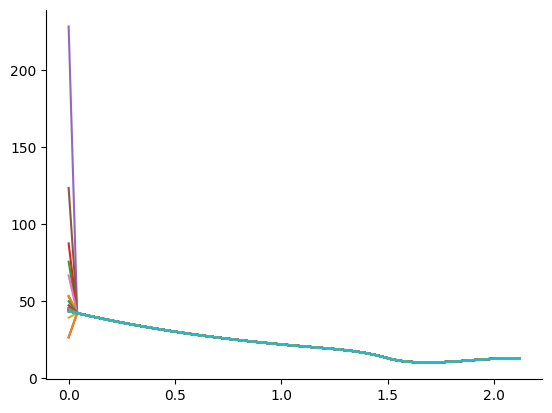

In [12]:
plt.plot(y1_grid_cap, ems)
plt.show()

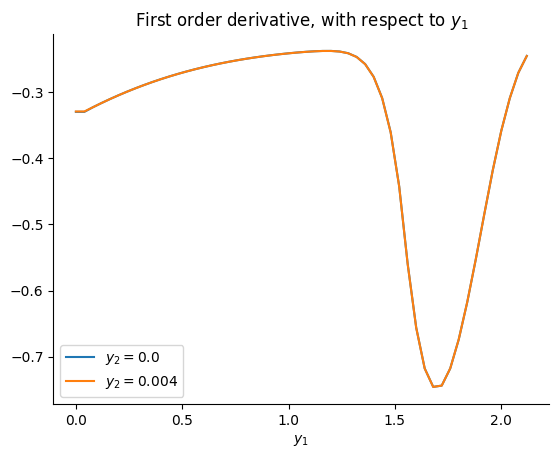

In [13]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

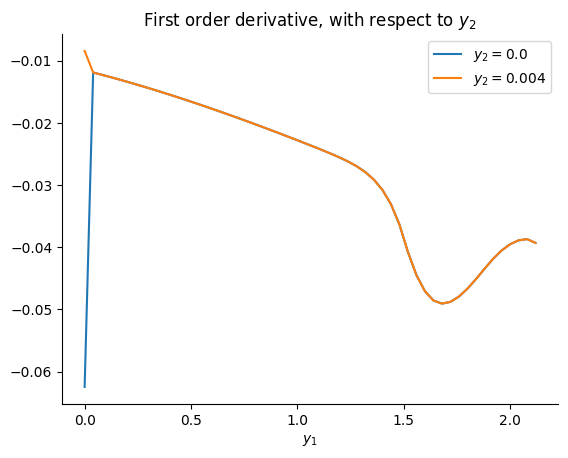

In [15]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

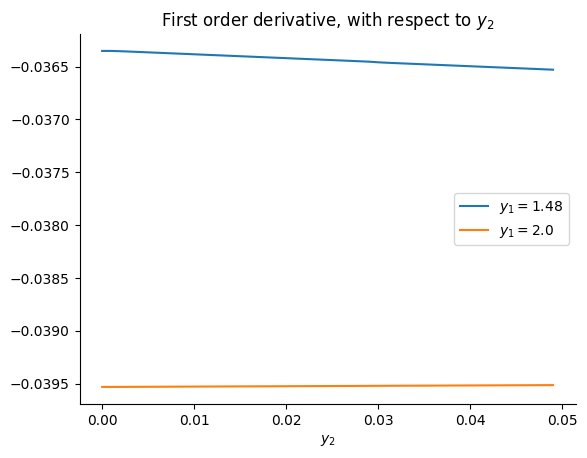

In [16]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

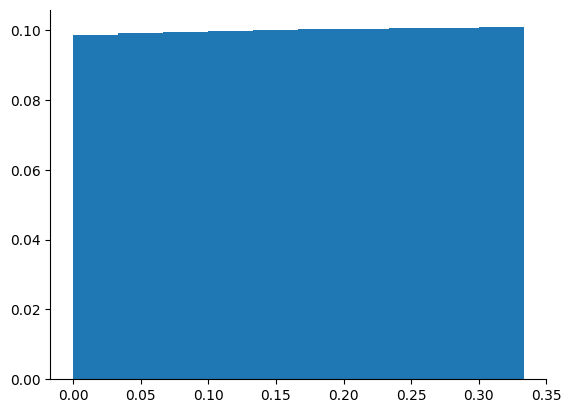

In [17]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

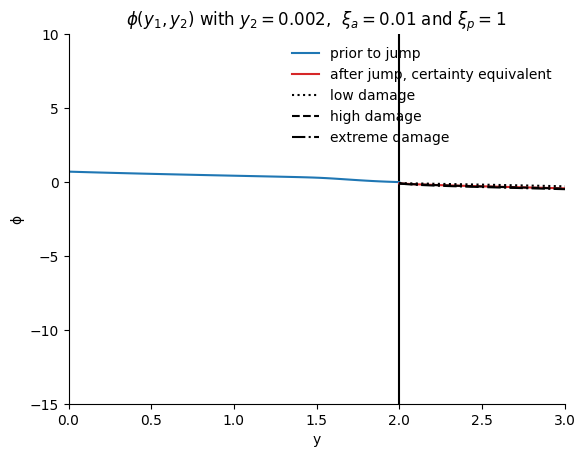

In [18]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

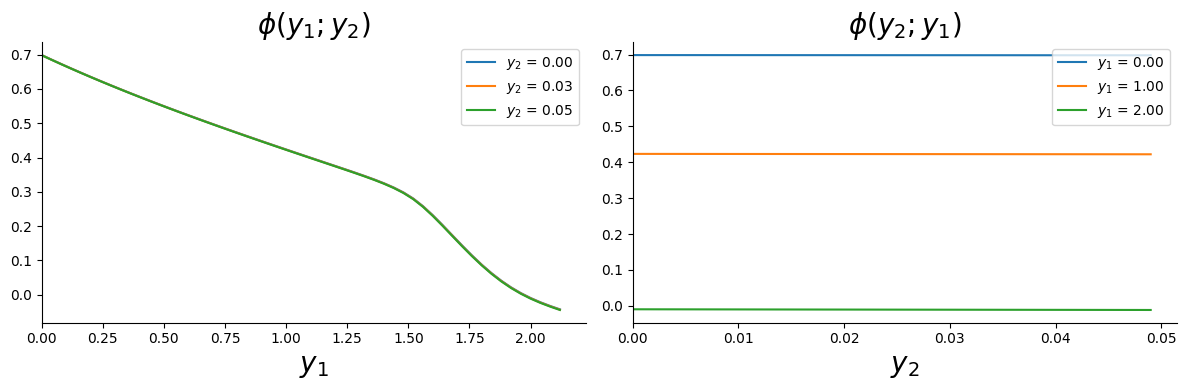

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

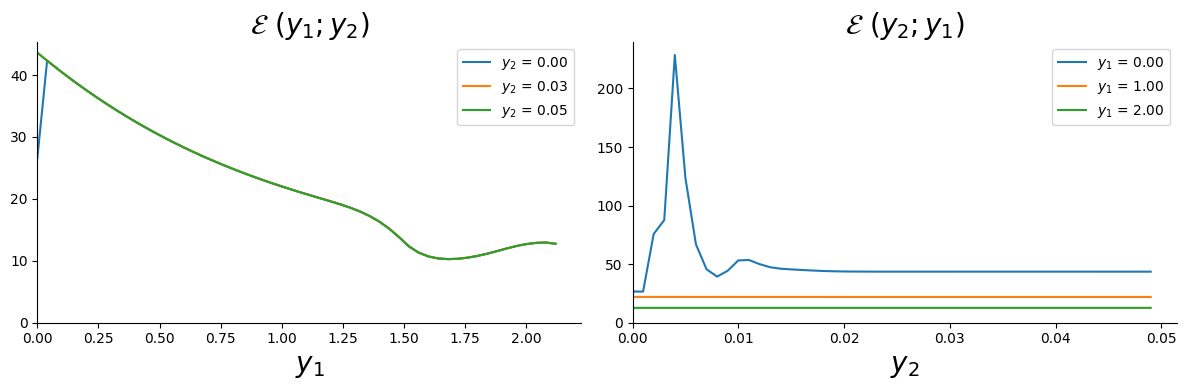

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [22]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [23]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [24]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [25]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [46]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

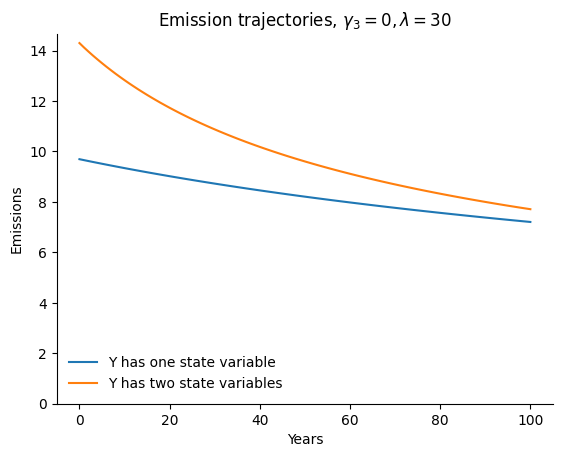

In [47]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [48]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=37
                                                 )

In [49]:
y1t_prejump

array([1.1       , 1.13870276, 1.17652866, 1.21353104, 1.24971329,
       1.28505219, 1.31949308, 1.35294599, 1.38524554, 1.41622658,
       1.44572909, 1.47362263, 1.49974824, 1.52411294, 1.54689082,
       1.56859093, 1.58942337, 1.60965753, 1.62944131, 1.64892498,
       1.66820304, 1.68738305, 1.70652167, 1.72570859, 1.74497723,
       1.76440687, 1.78401921, 1.80388583, 1.82402452, 1.84449915,
       1.86532732, 1.88655824, 1.90820512, 1.9302883 , 1.95279848,
       1.97572271, 1.99900598, 2.02262473])

In [60]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open(f"simul_{λ}", "wb"))

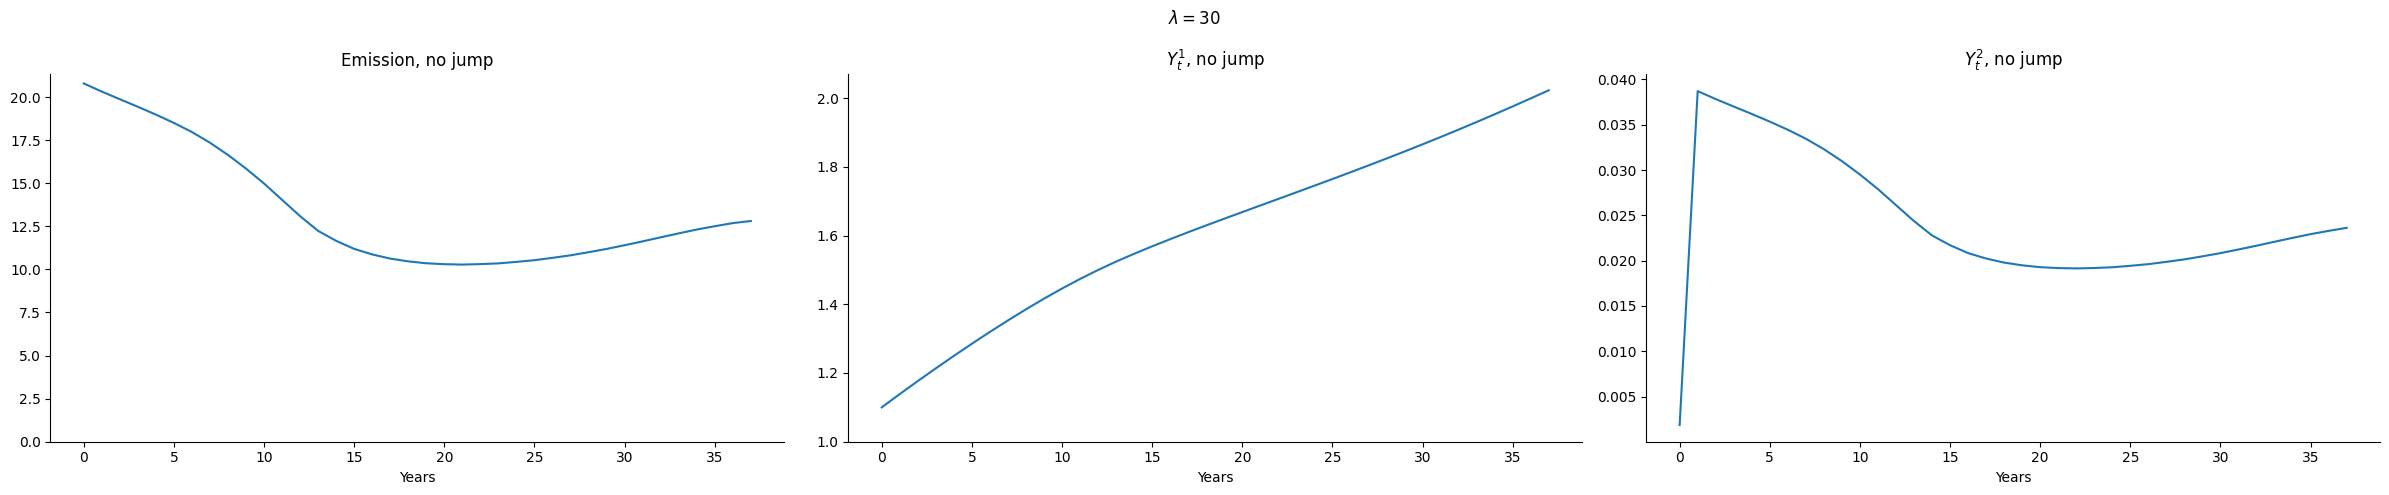

In [53]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$, no jump")
plt.plot(y2t_prejump)
# plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

In [54]:
y2_grid

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049])

In [55]:
y2t_prejump.max(), y2_grid[-1], y1t_prejump

(0.03870275852902258,
 0.049,
 array([1.1       , 1.13870276, 1.17652866, 1.21353104, 1.24971329,
        1.28505219, 1.31949308, 1.35294599, 1.38524554, 1.41622658,
        1.44572909, 1.47362263, 1.49974824, 1.52411294, 1.54689082,
        1.56859093, 1.58942337, 1.60965753, 1.62944131, 1.64892498,
        1.66820304, 1.68738305, 1.70652167, 1.72570859, 1.74497723,
        1.76440687, 1.78401921, 1.80388583, 1.82402452, 1.84449915,
        1.86532732, 1.88655824, 1.90820512, 1.9302883 , 1.95279848,
        1.97572271, 1.99900598, 2.02262473]))

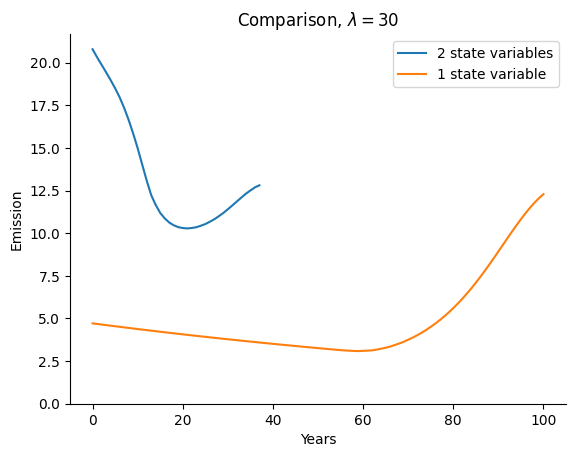

In [56]:
et_1state = np.load("et_1state.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [57]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [58]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

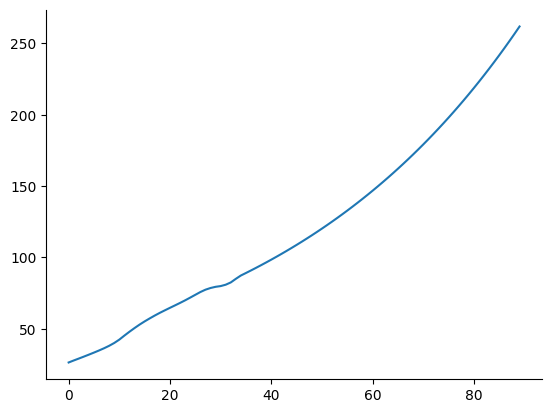

In [74]:
plt.plot(scc)
plt.show()

In [60]:
np.save(f"scct_{λ}", scc)